### import library

In [2]:
!git clone https://github.com/sung1eo/DIC4.git

Cloning into 'DIC4'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 129 (delta 54), reused 80 (delta 22), pack-reused 0
Receiving objects: 100% (129/129), 36.62 MiB | 25.56 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [3]:
!ls /content/DIC4/s.kim/

230215_data_concat.xlsx		  DNN_concat_fin.ipynb
230224_discrete_classifier.ipynb  DNN_concat.ipynb
230227_data_concat.xlsx		  EDA.ipynb
cnn_aug_window_dropout.ipynb	  modeling.ipynb
df_type_total_230403.csv	  preprocessing.ipynb
df_type_total_230407.csv	  rnn_lstm_window.ipynb
df_type_total.csv


In [4]:
### default
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import random
import time
import copy
from datetime import datetime
from scipy.interpolate import CubicSpline

### modeling
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

### visualization
import seaborn as sns
from matplotlib import pyplot as plt

### 파라미터 세팅

In [5]:
# 센서 종류
sensors = ['C7H8', 'TMA', 'VOC', 'CO2', 'HCHO', 'H2S', 'NH3', 'CH3SH', 'SO2', 'NO2', 'CO']
cols = ['C7H8', 'TMA', 'VOC', 'CO2', 'HCHO', 'H2S', 'NH3', 'CH3SH', 'SO2', 'NO2', 'CO', 'reg_date', 'label_type']

NUM_CLASSES = 6
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

### 데이터 불러오기, 학습/검증 데이터로 구분

In [6]:
# df = pd.read_csv('df_type_total_230403.csv') # 3~7차 데이터셋
df = pd.read_csv('/content/DIC4/s.kim/df_type_total_230407.csv') # 3~9차 데이터셋
df = df[cols]

In [7]:
df_train = df[pd.to_datetime(df['reg_date']) <= datetime(2023,4,1)]
df_test = df[pd.to_datetime(df['reg_date']) > datetime(2023,4,1)]

In [8]:
len(df), len(df_train), len(df_test)

(11627, 6531, 5096)

In [9]:
df_test['label_type'].value_counts()

B     2640
ME    2456
Name: label_type, dtype: int64

### 함수정의

#### data processing / plotting

In [10]:
# 데이터셋을 만들기 위한 실험 구분
def create_experiment_number(data):
    data['lagged'] = data['reg_date'].shift(-1)
    data['reg_date'] = pd.to_datetime(data['reg_date'])
    data['lagged'] = pd.to_datetime(data['lagged'])
    data['diff'] = data['lagged'] - data['reg_date']
    data['diff'] = data['diff'] /  pd.Timedelta('1s')
    data['diff'].fillna(1,inplace=True) #마지막줄 채워주기 위함
    data.reset_index(drop=True, inplace=True)

    num = 0
    for i in range(len(data)):
        if data.loc[i,'diff'] in [1,2]:
            data.loc[i,'exp_num'] = num
        else:
            data.loc[i,'exp_num'] = num
            num+=1
    data.drop(['lagged','diff'], axis='columns', inplace=True)
    return data

# 실험 별로 시계열 데이터셋을 만들기 위한 함수
def create_windows(data, window_size=5):
    X = []
    y = []
    for num, group_df in data.groupby('exp_num'):
        data = group_df.iloc[:, 0:11].values
        labels = group_df['label_type'].values
        for i in range(len(data) - window_size + 1):
            X.append(data[i:i+window_size])
            y.append(labels[window_size-1])

    return np.array(X), np.array(y)

# 데이터셋을 train/valid/test로 나누는 함수
def split_data(X, y, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    assert train_ratio + val_ratio + test_ratio == 1, "The sum of the ratios must be equal to 1."
    assert len(X) == len(y), "The length of X and y must be the same."
    
    # numpy 배열을 torch 텐서로 변환합니다.
    X = torch.from_numpy(X)
    y = torch.from_numpy(y)

    # 데이터를 무작위로 섞기 위한 인덱스를 생성합니다.
    shuffled_indices = torch.randperm(len(X))

    # 비율에 따라 인덱스를 설정합니다.
    train_cnt = int(len(X) * train_ratio)
    val_cnt = int(len(X) * val_ratio)
    test_cnt = len(X) - (train_cnt + val_cnt)

    # 데이터를 train, validation, test 셋으로 나눕니다 (torch.index_select 사용).
    X_train, X_val, X_test = torch.index_select(X, dim=0, index=shuffled_indices).split([train_cnt, val_cnt, test_cnt], dim=0)
    y_train, y_val, y_test = torch.index_select(y, dim=0, index=shuffled_indices).split([train_cnt, val_cnt, test_cnt], dim=0)
    
    print('---'*30)
    print('Splitting Complete')
    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
    return X_train, y_train, X_val, y_val, X_test, y_test

# torch dataloader를 만들기 위한 함수
def create_classification_dataset(data, window_size, batch_size):
    X, y = create_windows(data, window_size)
        
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

    encoder = LabelEncoder()
    y = encoder.fit_transform(y)
    y = to_categorical(y, num_classes=NUM_CLASSES)

    X = X.transpose(0,2,1)
    X = X.astype(np.float32)
    y = y.astype(np.float32)
       
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)

    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, encoder, scaler

# torch dataloader를 만들기 위한 함수
def create_test_dataset(data, window_size, batch_size, scaler, encoder):
    X, y = create_windows(data, window_size)

    X = scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
    y = encoder.transform(y)
    y = to_categorical(y, num_classes=NUM_CLASSES)

    X = X.transpose(0,2,1)
    X = X.astype(np.float32)
    y = y.astype(np.float32)

    # numpy 배열을 torch 텐서로 변환합니다.
    X = torch.from_numpy(X)
    y = torch.from_numpy(y)

    real_test_dataset = TensorDataset(X, y)

    # DataLoader 생성
    real_test_loader = DataLoader(real_test_dataset, batch_size=batch_size, shuffle=False)

    return real_test_loader

def plot_metrics(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    acc_list = [t.item() for t in history['train_acc']]
    val_acc_list = [t.item() for t in history['val_acc']]
    plt.plot(acc_list)
    plt.plot(val_acc_list)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')

    plt.show()

#### 학습용 데이터에 대한 증강 함수 정의

In [11]:
def add_gaussian_noise(data, mean, std_dev, noise_factor=0.1):
    noise = np.random.normal(0, std_dev * noise_factor, data.shape)
    augmented_data = data + noise
    augmented_data = np.where(augmented_data <= 0, data, augmented_data)
    return augmented_data

def scale_data_uniform_distribution(data, min_scale=0.8, max_scale=1.2):
    scaling_factor = np.random.uniform(min_scale, max_scale)
    augmented_data = data * scaling_factor
    # 방어 로직 추가
    augmented_data = np.where(augmented_data <= 0, data, augmented_data)
    return augmented_data

def scale_data_normal_distribution(data, mean_scale=1.0, std_dev_scale=0.1):
    scaling_factor = np.random.normal(mean_scale, std_dev_scale)
    augmented_data = data * scaling_factor
    # 방어 로직 추가
    augmented_data = np.where(augmented_data <= 0, data, augmented_data)
    return augmented_data

def shift_data(data, min_shift=-0.5, max_shift=0.5):
    shift_value = np.random.uniform(min_shift, max_shift)
    augmented_data = data + shift_value
    # 방어 로직 추가
    augmented_data = np.where(augmented_data <= 0, data, augmented_data)
    return augmented_data

def apply_jitter(data, mean, jitter_factor=0.05):
    jitter = np.random.uniform(-mean*jitter_factor, mean*jitter_factor, data.shape)
    augmented_data = data + jitter
    # 방어 로직 추가
    augmented_data = np.where(augmented_data <= 0, data, augmented_data)
    return augmented_data

def magnitude_warping_cubic_spline(data, num_knots=4, warping_range=0.2):
    knot_xs = np.linspace(0, 1, num_knots)
    # knot_ys = np.random.uniform(1 - warping_range, 1 + warping_range, num_knots)
    knot_ys = np.random.normal(1.0, warping_range, num_knots)
    cubic_spline = CubicSpline(knot_xs, knot_ys)
    
    data_len = len(data)
    xs = np.linspace(0, 1, data_len)
    warp_curve = cubic_spline(xs)
    
    # Reshape the warp_curve to match the data dimensions
    warp_curve = warp_curve.reshape(-1, 1)
    
    warped_data = data * warp_curve
    warped_data = np.where(warped_data <= 0, data, warped_data)
    return warped_data

def time_warping_cubic_spline(data, num_knots=4, warping_range=0.2):
    knot_xs = np.linspace(0, 1, num_knots)
    # knot_ys = np.random.uniform(1 - warping_range, 1 + warping_range, num_knots)
    knot_ys = np.random.normal(1.0, warping_range, num_knots)
    cubic_spline = CubicSpline(knot_xs, knot_ys)
    
    data_len = len(data)
    xs = np.linspace(0, 1, data_len)
    warp_curve = cubic_spline(xs)
    
    warped_xs = np.cumsum(warp_curve) / np.sum(warp_curve)
    
    # Use a loop to process each column of the data array independently
    warped_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        warped_data[:, i] = np.interp(xs, warped_xs, data[:, i])
    
    # 방어 로직 추가
    warped_data = np.where(warped_data <= 0, data, warped_data)
    return warped_data

### 데이터 증강

#### 데이터 전처리(실험 구분)

In [12]:
df_train = create_experiment_number(df_train)
df_train.head()

,C7H8,TMA,VOC,CO2,HCHO,H2S,NH3,CH3SH,SO2,NO2,CO,reg_date,label_type,exp_num
0,0.000000,0.000026,0.192282,435.1554,0.00000,0.303789,0.809661,0.0,0.050841,0.012979,0.323783,2023-03-13 12:52:05,B,0.0
1,0.000000,0.000034,0.357748,431.6093,0.00000,0.528598,3.488177,0.0,0.190711,0.000000,0.291240,2023-03-13 12:52:06,B,0.0
2,0.000000,0.000045,0.498292,326.9812,0.00000,0.688187,9.506214,0.0,0.233748,0.000000,0.230189,2023-03-13 12:52:08,B,0.0
3,0.000944,0.000057,0.728273,295.0207,0.00000,0.815260,9.946881,0.0,0.176365,0.000000,0.205769,2023-03-13 12:52:09,B,0.0
4,0.002350,0.000073,1.036101,324.5227,0.79195,0.911156,9.946881,0.0,0.130409,0.000000,0.150823,2023-03-13 12:52:10,B,0.0


In [13]:
# Calculate mean and standard deviation for each sensor (column) for each class
class_stats = {}

for label in df_train['label_type'].unique():
    class_data = df_train[df_train['label_type']==label]
    class_data = class_data[sensors].values
    means = np.mean(class_data, axis=0)
    std_devs = np.std(class_data, axis=0)
    class_stats[label] = {'means': means, 'std_devs': std_devs}

In [14]:
# Apply augmentation methods
raw_data = df_train[sensors].values
labels = df_train['label_type'].values
reg_dates = df_train['reg_date'].values
exp_nums = df_train['exp_num'].values

augmented_data_1 = []
for row, label in zip(raw_data, labels):
    augmented_row = np.zeros(row.shape)
    for i, value in enumerate(row):
        aug_value = add_gaussian_noise(value, class_stats[label]['means'][i], class_stats[label]['std_devs'][i], noise_factor=0.1)
        augmented_row[i] = aug_value
    augmented_data_1.append(augmented_row)
augmented_data_1 = np.array(augmented_data_1)

augmented_data_2 = []
for row, label in zip(raw_data, labels):
    augmented_row = np.zeros(row.shape)
    for i, value in enumerate(row):
        aug_value = scale_data_uniform_distribution(value)
        augmented_row[i] = aug_value
    augmented_data_2.append(augmented_row)
augmented_data_2 = np.array(augmented_data_2)

augmented_data_3 = []
for row, label in zip(raw_data, labels):
    augmented_row = np.zeros(row.shape)
    for i, value in enumerate(row):
        aug_value = scale_data_normal_distribution(value)
        augmented_row[i] = aug_value
    augmented_data_3.append(augmented_row)
augmented_data_3 = np.array(augmented_data_3)

# augmented_data_4 = []
# for row, label in zip(raw_data, labels):
#     augmented_row = np.zeros(row.shape)
#     for i, value in enumerate(row):
#         aug_value = shift_data(value)
#         augmented_row[i] = aug_value
#     augmented_data_4.append(augmented_row)
# augmented_data_4 = np.array(augmented_data_4)

augmented_data_5 = []
for row, label in zip(raw_data, labels):
    augmented_row = np.zeros(row.shape)
    for i, value in enumerate(row):
        aug_value = apply_jitter(value, class_stats[label]['means'][i] )
        augmented_row[i] = aug_value
    augmented_data_5.append(augmented_row)
augmented_data_5 = np.array(augmented_data_5)

augmented_data_6 = []
augmented_data_7 = []
for exp in df_train['exp_num'].unique():
    each = df_train[df_train['exp_num']==exp]
    each = each[sensors].values
    augmented_data_6.append(magnitude_warping_cubic_spline(each))
    augmented_data_7.append(time_warping_cubic_spline(each))

# convert (120, ) ==> (6531, 11)
augmented_data_6 = np.vstack(augmented_data_6) 
augmented_data_7 = np.vstack(augmented_data_7)

augmented_data_c1 = []
for row, label in zip(raw_data, labels):
    augmented_row = np.zeros(row.shape)
    for i, value in enumerate(row):
        aug_value = add_gaussian_noise(value, class_stats[label]['means'][i], class_stats[label]['std_devs'][i], noise_factor=0.1)
        aug_value = scale_data_uniform_distribution(aug_value)
        aug_value = apply_jitter(aug_value, class_stats[label]['means'][i])
        augmented_row[i] = aug_value
    augmented_data_c1.append(augmented_row)
augmented_data_c1 = np.array(augmented_data_c1)
augmented_data_c1 = pd.DataFrame(augmented_data_c1, columns=sensors)
augmented_data_c1['exp_num'] = exp_nums

augmented_data_8 = []
augmented_data_9 = []
for exp in augmented_data_c1['exp_num'].unique():
    each = augmented_data_c1[augmented_data_c1['exp_num']==exp]
    each = each[sensors].values
    augmented_data_8.append(magnitude_warping_cubic_spline(each))
    augmented_data_9.append(time_warping_cubic_spline(each))

# convert (120, ) ==> (6531, 11)
augmented_data_8 = np.vstack(augmented_data_8) 
augmented_data_9 = np.vstack(augmented_data_9)

# Save augmented data to a new DataFrame
augmented_df_1 = pd.DataFrame(augmented_data_1, columns=sensors)
augmented_df_1['label_type'] = labels
augmented_df_1['reg_date'] = reg_dates
augmented_df_1['exp_num'] = exp_nums
augmented_df_1['aug_type'] = 'gaussian_noise'
augmented_df_2 = pd.DataFrame(augmented_data_2, columns=sensors)
augmented_df_2['label_type'] = labels
augmented_df_2['reg_date'] = reg_dates
augmented_df_2['exp_num'] = exp_nums
augmented_df_2['aug_type'] = 'scaling(uniform)'
augmented_df_3 = pd.DataFrame(augmented_data_3, columns=sensors)
augmented_df_3['label_type'] = labels
augmented_df_3['reg_date'] = reg_dates
augmented_df_3['exp_num'] = exp_nums
augmented_df_3['aug_type'] = 'scaling(normal)'
# augmented_df_4 = pd.DataFrame(augmented_data_4, columns=sensors)
# augmented_df_4['label_type'] = labels
# augmented_df_4['reg_date'] = reg_dates
# augmented_df_4['exp_num'] = exp_nums
augmented_df_5 = pd.DataFrame(augmented_data_5, columns=sensors)
augmented_df_5['label_type'] = labels
augmented_df_5['reg_date'] = reg_dates
augmented_df_5['exp_num'] = exp_nums
augmented_df_5['aug_type'] = 'jittering'
augmented_df_6 = pd.DataFrame(augmented_data_6, columns=sensors)
augmented_df_6['label_type'] = labels
augmented_df_6['reg_date'] = reg_dates
augmented_df_6['exp_num'] = exp_nums
augmented_df_6['aug_type'] = 'magnitude_warping'
augmented_df_7 = pd.DataFrame(augmented_data_7, columns=sensors)
augmented_df_7['label_type'] = labels
augmented_df_7['reg_date'] = reg_dates
augmented_df_7['exp_num'] = exp_nums
augmented_df_7['aug_type'] = 'time_warping'
augmented_df_8 = pd.DataFrame(augmented_data_8, columns=sensors)
augmented_df_8['label_type'] = labels
augmented_df_8['reg_date'] = reg_dates
augmented_df_8['exp_num'] = exp_nums
augmented_df_8['aug_type'] = 'combination1'
augmented_df_9 = pd.DataFrame(augmented_data_9, columns=sensors)
augmented_df_9['label_type'] = labels
augmented_df_9['reg_date'] = reg_dates
augmented_df_9['exp_num'] = exp_nums
augmented_df_9['aug_type'] = 'combination2'

augmented_df = pd.concat([augmented_df_1, augmented_df_2, augmented_df_3
# , augmented_df_4
, augmented_df_5, augmented_df_6, augmented_df_7, augmented_df_8, augmented_df_9])
augmented_df.reset_index(drop=True, inplace=True)
augmented_df['is_aug'] = 1

In [15]:
df_train['is_aug'] = 0
df_train['aug_type'] = 'original'
df_train_total = pd.concat([df_train,augmented_df])

In [16]:
df_train_total['is_aug'].value_counts()

1    52248
0     6531
Name: is_aug, dtype: int64

In [17]:
df_train_total.groupby(['is_aug','label_type']).mean()

C7H8       TMA       VOC          CO2      HCHO  \
is_aug label_type                                                        
0      A           0.009780  0.000033  0.315670  3282.466437  0.000512   
       B           0.062161  0.000261  3.786709   280.845259  9.511448   
       C           0.003430  0.000031  0.275784  2549.303650  0.000227   
       EN          0.026686  0.000040  0.482237    39.275725  0.007571   
       ME          0.036099  0.000114  0.794137   192.520571  0.775849   
       MO          0.016899  0.000060  0.768089    78.141789  0.006571   
1      A           0.009745  0.000033  0.315625  3274.760361  0.000814   
       B           0.061421  0.000259  3.746935   280.879640  9.399062   
       C           0.003451  0.000030  0.274362  2526.889541  0.000345   
       EN          0.026680  0.000040  0.481714    41.471526  0.010057   
       ME          0.035805  0.000113  0.789789   193.973104  0.768633   
       MO          0.016761  0.000060  0.765341    80.191152  0.008042   

                        H2S       NH3     CH3SH       SO2       NO2        CO  \
is_aug label_type                                                               
0      A           0.888562  2.129120  0.009476  0.024296  0.011137  0.574519   
       B           0.894038  9.492534  0.000244  0.007592  0.012404  0.588091   
       C           0.939731  2.102958  0.010678  0.035658  0.006109  0.274356   
       EN          0.805855  4.409067  0.002131  0.014499  0.023759  0.398367   
       ME          1.014770  6.617821  0.073342  0.006931  0.007405  0.696040   
       MO          0.811076  8.925683  0.006587  0.010757  0.021719  0.542908   
1      A           0.884976  2.120094  0.009764  0.024332  0.011762  0.576086   
       B           0.884092  9.406619  0.000270  0.007845  0.013989  0.585732   
       C           0.931266  2.085255  0.010848  0.035728  0.006607  0.273874   
       EN          0.803674  4.374996  0.002113  0.014685  0.025131  0.400592   
       ME          1.011102  6.563165  0.074217  0.007198  0.007991  0.697045   
       MO          0.804885  8.871865  0.006659  0.011184  0.023738  0.545723   

                     exp_num  
is_aug label_type             
0      A           76.753223  
       B           56.766493  
       C           77.087737  
       EN          66.741490  
       ME          56.117647  
       MO          62.390223  
1      A           76.753223  
       B           56.766493  
       C           77.087737  
       EN          66.741490  
       ME          56.117647  
       MO          62.390223

### pytorch를 사용한 딥러닝 모델 구현

In [18]:
# Hyperparameter setting
batch_size = 32
num_classes = NUM_CLASSES
num_epochs = 50
window_size = 7
feature_len = 11

# RNN Parameter
hidden_size = 64
num_layers = 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Detect if we have a GPU available

In [19]:
# seed 고정
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [20]:
# Dataloader 구축
# data shape: (batch_size x input_size x seq_len) => (32, 11, 5)
train_loader, valid_loader, test_loader, encoder, scaler = create_classification_dataset(df_train_total, window_size, batch_size)

------------------------------------------------------------------------------------------
Splitting Complete
torch.Size([46447, 11, 7]) torch.Size([46447, 6]) torch.Size([5805, 11, 7]) torch.Size([5805, 6]) torch.Size([5807, 11, 7]) torch.Size([5807, 6])


In [21]:
# 증강이 없는 Dataloader 구축
# data shape: (batch_size x input_size x seq_len) => (32, 11, 5)
noaug_train_loader, noaug_valid_loader, noaug_test_loader, noaug_encoder, noaug_scaler = create_classification_dataset(df_train_total[df_train_total['is_aug']==0], window_size, batch_size)

------------------------------------------------------------------------------------------
Splitting Complete
torch.Size([4648, 11, 7]) torch.Size([4648, 6]) torch.Size([581, 11, 7]) torch.Size([581, 6]) torch.Size([582, 11, 7]) torch.Size([582, 6])


In [22]:
# DataLoader에서 데이터 형태 확인
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1} - Inputs shape: {inputs.shape}, Targets shape: {targets.shape}")
    break

Batch 1 - Inputs shape: torch.Size([32, 11, 7]), Targets shape: torch.Size([32, 6])


In [23]:
# DataLoader에서 데이터 형태 확인
for batch_idx, (inputs, targets) in enumerate(test_loader):
    print(f"Batch {batch_idx + 1} - Inputs shape: {inputs.shape}, Targets shape: {targets.shape}")
    break

Batch 1 - Inputs shape: torch.Size([32, 11, 7]), Targets shape: torch.Size([32, 6])


In [24]:
# 1-dimensional convolution layer로 구성된 CNN 모델
# 2개의 1-dimensional convolution layer와 1개의 fully-connected layer로 구성되어 있음
class CNN_1D(nn.Module):
    def __init__(self, in_channel, out_channel, num_classes, dropout_rate=0.2):

        self.in_channel = in_channel
        self.out_channel = out_channel
        self.num_classes = num_classes

        super(CNN_1D, self).__init__()
        # 첫 번째 1-dimensional convolution layer 구축
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channel, out_channel, kernel_size=3, padding=1),
            nn.ReLU(),
#             nn.AvgPool1d(kernel_size=2, stride=2),
            # nn.MaxPool1d(kernel_size=2, stride=2)
            nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(dropout_rate)
        )
        # 두 번째 1-dimensional convolution layer 구축
        self.layer2 = nn.Sequential(
            nn.Conv1d(out_channel, 32, kernel_size=3, padding=1),
            nn.ReLU(),
#             nn.AvgPool1d(kernel_size=2, stride=2),
            # nn.MaxPool1d(kernel_size=2, stride=2)
            nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(dropout_rate)
        )
        # fully-connected layer 구축
        self.fc = nn.Linear(32*1, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [25]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.2, bidirectional=False, rnn_type='rnn'):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn_type = rnn_type.lower()
        self.num_directions = 2 if bidirectional == True else 1
        self.dropout_rate = dropout_rate
        self.bidirectional = bidirectional
        
        if self.rnn_type == 'rnn':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate, bidirectional=bidirectional)
        elif self.rnn_type == 'lstm':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate, bidirectional=bidirectional)
        elif self.rnn_type == 'gru':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate, bidirectional=bidirectional)
        else:
            raise ValueError(f"Invalid rnn_type: {rnn_type}, expected one of ['rnn', 'lstm', 'gru']")
        
        # bidirectional에 따른 fc layer 구축
        # bidirectional 여부에 따라 hidden state의 shape가 달라짐 (True: 2 * hidden_size, False: hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(self.num_directions * hidden_size, num_classes)

    def forward(self, x):
        # data dimension: (batch_size x input_size x seq_len) -> (batch_size x seq_len x input_size)로 변환
        x = torch.transpose(x, 1, 2) # x.permute(0, 2, 1) 와 결과적으로는 동일
        rnn_out, hidden = self.rnn(x)

        # LSTMs, the hidden state is a tuple containing both the hidden state and cell state. 
        if self.rnn_type == 'lstm':
            hidden_state, _ = hidden
        else:
            hidden_state = hidden

        # 인자로 받은 bidirectional 값을 사용하기 위해 self.bidirectional을 사용한다
        if self.bidirectional:
            forward_out = rnn_out[:, -1, :self.hidden_size]
            backward_out = rnn_out[:, 0, self.hidden_size:]
            last_time_step_out = torch.cat((forward_out, backward_out), dim=1)
        else:
            last_time_step_out = rnn_out[:, -1, :]
        
        dropped_out = self.dropout(last_time_step_out)
        out = self.fc(dropped_out)
        
        return out

In [26]:
class CRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.2, kernel_size=3, num_layers=1):
        super(CRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=kernel_size, stride=1, padding=1),
            nn.BatchNorm1d(num_features=32),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=kernel_size, stride=1, padding=1),
            nn.BatchNorm1d(num_features=64),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=kernel_size, stride=1, padding=1),
            nn.BatchNorm1d(num_features=128),
            nn.ReLU(),
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=kernel_size, stride=1, padding=1),
            nn.BatchNorm1d(num_features=256),
            nn.ReLU(),
        )
        self.dropout_cnn_rnn = nn.Dropout(dropout_rate)
        self.rnn = nn.GRU(input_size=256, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=(0 if num_layers == 1 else dropout_rate))
        self.dropout_rnn_fc = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.cnn(x)
        x = x.permute(0, 2, 1)  # (batch_size, window_size, feature_size)
        x = self.dropout_cnn_rnn(x)
        output, hidden = self.rnn(x)
        output = self.dropout_rnn_fc(output[:, -1, :])
        output = self.fc(output)
        return output

In [27]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size, output_size, window_size, num_layers=1, hidden_size=64, dropout_rate=0.2):
        super().__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        self.window_size = window_size
        
        # Define the transformer encoder layers
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=self.input_size, nhead=11, dim_feedforward=256, dropout=dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=num_layers)
        
        # Define the fully connected output layers
        self.fc1 = nn.Linear(input_size*window_size, hidden_size) #77차원 input을 받기 위함
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # x is a tensor of shape (batch_size, feature_len, window_size)
        
        # Permute the tensor to (window_size, batch_size, feature_len) for input into the transformer encoder
        x = x.permute(2, 0, 1)
        
        # Pass the tensor through the transformer encoder
        x = self.transformer_encoder(x)
        
        # Reshape the tensor back to (batch_size, window_size, feature_len) for input into the fully connected layers
        x = x.permute(1, 0, 2)
        # x = x.reshape(x.size(0), -1)

        x = self.fc1(x.reshape(x.size(0), -1)) #(32,7,11) --> (32,77) 차원으로 변환
        
        # Pass the tensor through the fully connected layers
        x = nn.functional.relu(x)
        x = self.fc2(x)
        
        # Return the logits
        return x

In [ ]:
# 1D CNN 구축
cnn_default = CNN_1D(in_channel=feature_len, out_channel=16, num_classes=NUM_CLASSES, dropout_rate=0) # in_channel은 feature의 갯수
cnn_default = cnn_default.to(device)
print(cnn_default)

CNN_1D(
  (layer1): Sequential(
    (0): Conv1d(11, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc): Linear(in_features=32, out_features=6, bias=True)
)


In [ ]:
# 1D CNN with dropout 구축
cnn_dropout = CNN_1D(in_channel=feature_len, out_channel=16, num_classes=NUM_CLASSES, dropout_rate=0.25) # in_channel은 feature의 갯수
cnn_dropout = cnn_dropout.to(device)
print(cnn_dropout)

CNN_1D(
  (layer1): Sequential(
    (0): Conv1d(11, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (fc): Linear(in_features=32, out_features=6, bias=True)
)


In [ ]:
# Bi-GRU 모델 구축
gru_default = RNN(feature_len, hidden_size, num_layers, num_classes, dropout_rate=0, bidirectional=True, rnn_type='gru')
gru_default = gru_default.to(device)
print(gru_default)

RNN(
  (rnn): GRU(11, 64, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)


In [28]:
# Bi-GRU 모델 구축 with dropout
# hidden_size = 64
gru_dropout = RNN(feature_len, hidden_size, num_layers, num_classes, dropout_rate=0.25, bidirectional=True, rnn_type='gru')
gru_dropout = gru_dropout.to(device)
print(gru_dropout)

RNN(
  (rnn): GRU(11, 64, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)


In [ ]:
crnn_dropout = CRNN

In [ ]:
transformer_default = TimeSeriesTransformer(input_size=feature_len, output_size=num_classes, num_layers=1, hidden_size=64, dropout_rate=0)
# transformer_default = TimeSeriesTransformer(input_size=feature_len+1, output_size=6)
transformer_default = transformer_default.to(device)
print(transformer_default)

TimeSeriesTransformer(
  (transformer_encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=11, out_features=11, bias=True)
    )
    (linear1): Linear(in_features=11, out_features=256, bias=True)
    (dropout): Dropout(p=0, inplace=False)
    (linear2): Linear(in_features=256, out_features=11, bias=True)
    (norm1): LayerNorm((11,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((11,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
    (dropout2): Dropout(p=0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=11, out_features=11, bias=True)
        )
        (linear1): Linear(in_features=11, out_features=256, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (

In [100]:
transformer_dropout = TimeSeriesTransformer(input_size=feature_len, output_size=num_classes, window_size=window_size, num_layers=1, hidden_size=64, dropout_rate=0.5)
# transformer_default = TimeSeriesTransformer(input_size=feature_len+1, output_size=6)
transformer_dropout = transformer_dropout.to(device)
print(transformer_dropout)

TimeSeriesTransformer(
  (transformer_encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=11, out_features=11, bias=True)
    )
    (linear1): Linear(in_features=11, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (linear2): Linear(in_features=256, out_features=11, bias=True)
    (norm1): LayerNorm((11,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((11,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.5, inplace=False)
    (dropout2): Dropout(p=0.5, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=11, out_features=11, bias=True)
        )
        (linear1): Linear(in_features=11, out_features=256, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
 

In [29]:
def train_model(model, dataloaders, criterion, num_epochs, optimizer):
    since = time.time()

    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        train_loss = 0
        val_loss = 0
        train_corrects = 0
        val_corrects = 0
        train_total = 0
        val_total = 0

        # 각 epoch마다 순서대로 training과 validation을 진행
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 training mode로 설정
            else:
                model.eval()   # 모델을 validation mode로 설정            

            # training과 validation 단계에 맞는 dataloader에 대하여 학습/검증 진행
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                assert inputs.size(0) == labels.size(0), "Expected input batch_size (%d) to match target batch_size (%d)." % (inputs.size(0), labels.size(0))

                # parameter gradients를 0으로 설정
                optimizer.zero_grad()

                # forward
                # training 단계에서만 gradient 업데이트 수행
                with torch.set_grad_enabled(phase == 'train'):
                    # input을 model에 넣어 output을 도출한 후, loss를 계산함
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # output 중 최댓값의 위치에 해당하는 class로 예측을 수행
                    _, preds = torch.max(outputs, 1)

                    # backward (optimize): training 단계에서만 수행
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # batch별 loss를 축적함
                if phase == 'train':
                    # running_loss += loss.item() * inputs.size(0)
                    # running_corrects += torch.sum(preds == torch.argmax(labels, dim=-1))
                    # running_total += labels.size(0)

                    train_loss += loss.item() * inputs.size(0)
                    # train_loss += loss.item() 
                    train_corrects += torch.sum(preds == torch.argmax(labels, dim=-1))
                    train_total += labels.size(0)

                else:
                    val_loss += loss.item() * inputs.size(0)
                    # val_loss += loss.item()
                    val_corrects += torch.sum(preds == torch.argmax(labels, dim=-1))
                    val_total += labels.size(0)
            
        train_loss_epoch = train_loss/train_total
        val_loss_epoch = val_loss/val_total
        train_acc_epoch = train_corrects.double() /train_total
        val_acc_epoch = val_corrects.double() /val_total

        # epoch의 loss 및 accuracy 도출
        # epoch_loss = running_loss / running_total
        # epoch_acc = running_corrects.double() / running_total

        # validation 단계에서 validation loss가 감소할 때마다 best model 가중치를 업데이트함
        if phase == 'val' and val_acc_epoch > best_acc:
            best_acc = val_acc_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            print('update model parameter')

        train_acc_history.append(train_acc_epoch)
        val_acc_history.append(val_acc_epoch)
        train_loss_history.append(train_loss_epoch)
        val_loss_history.append(val_loss_epoch)
            
            # if phase == 'val':
            #     val_acc_history.append(val_acc_epoch)
            
        print(f'{epoch+1} epoch | Train loss: {train_loss_epoch:.3f}, Valid loss: {val_loss_epoch:.3f}, Train acc: {train_acc_epoch:.3f}, Valid acc: {val_acc_epoch:.3f}')
        # print(f'{epoch+1} epoch | Train acc: {train_acc_epoch:.3f}, Valid acc: {val_acc_epoch:.3f}')
        print()

    # 전체 학습 시간 계산
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # validation loss가 가장 낮았을 때의 best model 가중치를 불러와 best model을 구축함
    model.load_state_dict(best_model_wts)
    history = {'train_acc':train_acc_history, 'val_acc':val_acc_history, 'train_loss':train_loss_history, 'val_loss':val_loss_history}
    
    # best model 가중치 저장
    # torch.save(best_model_wts, '../output/best_model.pt')
    return model, history

In [30]:
# trining 단계에서 사용할 Dataloader dictionary 생성
dataloaders_dict = {
    'train': train_loader,
    'val': valid_loader
}

noaug_dataloaders_dict = {
    'train': noaug_train_loader,
    'val': noaug_valid_loader
}

# loss function 설정
criterion = nn.CrossEntropyLoss()

In [ ]:
# 모델 학습
cnn_default_model, history = train_model(cnn_default, dataloaders_dict, criterion, num_epochs, optimizer=optim.Adam(cnn_default.parameters(), lr=0.001))

Epoch 1/50
----------
update model parameter
1 epoch | Train loss: 0.637, Valid loss: 0.407, Train acc: 0.738, Valid acc: 0.823

Epoch 2/50
----------
update model parameter
2 epoch | Train loss: 0.350, Valid loss: 0.310, Train acc: 0.853, Valid acc: 0.877

Epoch 3/50
----------
update model parameter
3 epoch | Train loss: 0.279, Valid loss: 0.269, Train acc: 0.883, Valid acc: 0.893

Epoch 4/50
----------
update model parameter
4 epoch | Train loss: 0.239, Valid loss: 0.245, Train acc: 0.900, Valid acc: 0.900

Epoch 5/50
----------
update model parameter
5 epoch | Train loss: 0.209, Valid loss: 0.201, Train acc: 0.916, Valid acc: 0.925

Epoch 6/50
----------
6 epoch | Train loss: 0.186, Valid loss: 0.185, Train acc: 0.927, Valid acc: 0.918

Epoch 7/50
----------
update model parameter
7 epoch | Train loss: 0.166, Valid loss: 0.163, Train acc: 0.937, Valid acc: 0.937

Epoch 8/50
----------
update model parameter
8 epoch | Train loss: 0.152, Valid loss: 0.153, Train acc: 0.942, Valid acc

In [ ]:
# 모델 학습
cnn_dropout_model, cnn_dropout_history = train_model(cnn_dropout, dataloaders_dict, criterion, num_epochs, optimizer=optim.Adam(cnn_dropout.parameters(), lr=0.001))

Epoch 1/50
----------
update model parameter
1 epoch | Train loss: 0.767, Valid loss: 0.482, Train acc: 0.669, Valid acc: 0.799

Epoch 2/50
----------
update model parameter
2 epoch | Train loss: 0.489, Valid loss: 0.375, Train acc: 0.787, Valid acc: 0.848

Epoch 3/50
----------
update model parameter
3 epoch | Train loss: 0.406, Valid loss: 0.302, Train acc: 0.825, Valid acc: 0.868

Epoch 4/50
----------
update model parameter
4 epoch | Train loss: 0.350, Valid loss: 0.262, Train acc: 0.848, Valid acc: 0.884

Epoch 5/50
----------
update model parameter
5 epoch | Train loss: 0.309, Valid loss: 0.224, Train acc: 0.866, Valid acc: 0.901

Epoch 6/50
----------
update model parameter
6 epoch | Train loss: 0.281, Valid loss: 0.203, Train acc: 0.880, Valid acc: 0.912

Epoch 7/50
----------
update model parameter
7 epoch | Train loss: 0.260, Valid loss: 0.192, Train acc: 0.888, Valid acc: 0.915

Epoch 8/50
----------
8 epoch | Train loss: 0.245, Valid loss: 0.184, Train acc: 0.896, Valid acc

In [ ]:
# 모델 학습
noaug_cnn_default_model, noaug_cnn_default_history = train_model(cnn_default, noaug_dataloaders_dict, criterion, num_epochs, optimizer=optim.Adam(cnn_default.parameters(), lr=0.001))

Epoch 1/50
----------
update model parameter
1 epoch | Train loss: 0.121, Valid loss: 0.116, Train acc: 0.959, Valid acc: 0.967

Epoch 2/50
----------
2 epoch | Train loss: 0.119, Valid loss: 0.124, Train acc: 0.959, Valid acc: 0.960

Epoch 3/50
----------
3 epoch | Train loss: 0.120, Valid loss: 0.119, Train acc: 0.959, Valid acc: 0.954

Epoch 4/50
----------
4 epoch | Train loss: 0.113, Valid loss: 0.113, Train acc: 0.961, Valid acc: 0.967

Epoch 5/50
----------
update model parameter
5 epoch | Train loss: 0.114, Valid loss: 0.109, Train acc: 0.960, Valid acc: 0.969

Epoch 6/50
----------
6 epoch | Train loss: 0.109, Valid loss: 0.113, Train acc: 0.964, Valid acc: 0.964

Epoch 7/50
----------
7 epoch | Train loss: 0.109, Valid loss: 0.106, Train acc: 0.961, Valid acc: 0.969

Epoch 8/50
----------
8 epoch | Train loss: 0.112, Valid loss: 0.105, Train acc: 0.958, Valid acc: 0.967

Epoch 9/50
----------
9 epoch | Train loss: 0.104, Valid loss: 0.110, Train acc: 0.965, Valid acc: 0.962



In [ ]:
# 모델 학습
noaug_gru_default_model, noaug_gru_default_history = train_model(gru_default, noaug_dataloaders_dict, criterion, num_epochs, optimizer=optim.Adam(gru_default.parameters(), lr=0.001))

Epoch 1/50
----------
update model parameter
1 epoch | Train loss: 0.938, Valid loss: 0.603, Train acc: 0.605, Valid acc: 0.778

Epoch 2/50
----------
update model parameter
2 epoch | Train loss: 0.496, Valid loss: 0.427, Train acc: 0.795, Valid acc: 0.816

Epoch 3/50
----------
update model parameter
3 epoch | Train loss: 0.406, Valid loss: 0.365, Train acc: 0.829, Valid acc: 0.836

Epoch 4/50
----------
4 epoch | Train loss: 0.357, Valid loss: 0.364, Train acc: 0.840, Valid acc: 0.830

Epoch 5/50
----------
update model parameter
5 epoch | Train loss: 0.321, Valid loss: 0.319, Train acc: 0.864, Valid acc: 0.847

Epoch 6/50
----------
update model parameter
6 epoch | Train loss: 0.271, Valid loss: 0.287, Train acc: 0.884, Valid acc: 0.869

Epoch 7/50
----------
update model parameter
7 epoch | Train loss: 0.259, Valid loss: 0.276, Train acc: 0.892, Valid acc: 0.881

Epoch 8/50
----------
update model parameter
8 epoch | Train loss: 0.218, Valid loss: 0.213, Train acc: 0.912, Valid acc

In [ ]:
# 모델 학습
noaug_tfm_default_model, noaug_tfm_default_history = train_model(transformer_default, noaug_dataloaders_dict, criterion, num_epochs, optimizer=optim.Adam(transformer_default.parameters(), lr=0.001))

Epoch 1/50
----------
update model parameter
1 epoch | Train loss: 0.806, Valid loss: 0.489, Train acc: 0.694, Valid acc: 0.781

Epoch 2/50
----------
update model parameter
2 epoch | Train loss: 0.383, Valid loss: 0.349, Train acc: 0.840, Valid acc: 0.849

Epoch 3/50
----------
update model parameter
3 epoch | Train loss: 0.229, Valid loss: 0.200, Train acc: 0.914, Valid acc: 0.914

Epoch 4/50
----------
update model parameter
4 epoch | Train loss: 0.157, Valid loss: 0.153, Train acc: 0.935, Valid acc: 0.948

Epoch 5/50
----------
update model parameter
5 epoch | Train loss: 0.117, Valid loss: 0.118, Train acc: 0.959, Valid acc: 0.954

Epoch 6/50
----------
6 epoch | Train loss: 0.097, Valid loss: 0.112, Train acc: 0.964, Valid acc: 0.954

Epoch 7/50
----------
update model parameter
7 epoch | Train loss: 0.097, Valid loss: 0.105, Train acc: 0.964, Valid acc: 0.957

Epoch 8/50
----------
update model parameter
8 epoch | Train loss: 0.083, Valid loss: 0.095, Train acc: 0.972, Valid acc

In [ ]:
# 모델 학습
gru_default_model, gru_default_history = train_model(gru_default, dataloaders_dict, criterion, num_epochs, optimizer=optim.Adam(gru_default.parameters(), lr=0.001))

Epoch 1/50
----------
update model parameter
1 epoch | Train loss: 0.438, Valid loss: 0.264, Train acc: 0.814, Valid acc: 0.889

Epoch 2/50
----------
update model parameter
2 epoch | Train loss: 0.201, Valid loss: 0.171, Train acc: 0.916, Valid acc: 0.929

Epoch 3/50
----------
update model parameter
3 epoch | Train loss: 0.110, Valid loss: 0.085, Train acc: 0.957, Valid acc: 0.966

Epoch 4/50
----------
update model parameter
4 epoch | Train loss: 0.076, Valid loss: 0.048, Train acc: 0.972, Valid acc: 0.982

Epoch 5/50
----------
5 epoch | Train loss: 0.058, Valid loss: 0.045, Train acc: 0.979, Valid acc: 0.982

Epoch 6/50
----------
6 epoch | Train loss: 0.042, Valid loss: 0.076, Train acc: 0.984, Valid acc: 0.969

Epoch 7/50
----------
update model parameter
7 epoch | Train loss: 0.039, Valid loss: 0.029, Train acc: 0.985, Valid acc: 0.989

Epoch 8/50
----------
8 epoch | Train loss: 0.031, Valid loss: 0.045, Train acc: 0.988, Valid acc: 0.982

Epoch 9/50
----------
update model pa

In [31]:
# 모델 학습
gru_dropout_model, gru_dropout_history = train_model(gru_dropout, dataloaders_dict, criterion, num_epochs, optimizer=optim.Adam(gru_dropout.parameters(), lr=0.001))

Epoch 1/50
----------
update model parameter
1 epoch | Train loss: 0.466, Valid loss: 0.298, Train acc: 0.802, Valid acc: 0.875

Epoch 2/50
----------
update model parameter
2 epoch | Train loss: 0.234, Valid loss: 0.158, Train acc: 0.904, Valid acc: 0.938

Epoch 3/50
----------
update model parameter
3 epoch | Train loss: 0.150, Valid loss: 0.104, Train acc: 0.941, Valid acc: 0.957

Epoch 4/50
----------
update model parameter
4 epoch | Train loss: 0.108, Valid loss: 0.065, Train acc: 0.958, Valid acc: 0.978

Epoch 5/50
----------
5 epoch | Train loss: 0.088, Valid loss: 0.064, Train acc: 0.966, Valid acc: 0.975

Epoch 6/50
----------
update model parameter
6 epoch | Train loss: 0.071, Valid loss: 0.051, Train acc: 0.974, Valid acc: 0.981

Epoch 7/50
----------
update model parameter
7 epoch | Train loss: 0.061, Valid loss: 0.033, Train acc: 0.977, Valid acc: 0.989

Epoch 8/50
----------


KeyboardInterrupt: ignored

In [ ]:
# 모델 학습
tfm_default_model, tfm_default_history = train_model(transformer_default, dataloaders_dict, criterion, num_epochs, optimizer=optim.Adam(transformer_default.parameters(), lr=0.001))

Epoch 1/50
----------
update model parameter
1 epoch | Train loss: 0.273, Valid loss: 0.138, Train acc: 0.890, Valid acc: 0.941

Epoch 2/50
----------
update model parameter
2 epoch | Train loss: 0.093, Valid loss: 0.082, Train acc: 0.964, Valid acc: 0.963

Epoch 3/50
----------
update model parameter
3 epoch | Train loss: 0.062, Valid loss: 0.056, Train acc: 0.976, Valid acc: 0.977

Epoch 4/50
----------
update model parameter
4 epoch | Train loss: 0.051, Valid loss: 0.053, Train acc: 0.981, Valid acc: 0.978

Epoch 5/50
----------
update model parameter
5 epoch | Train loss: 0.037, Valid loss: 0.026, Train acc: 0.986, Valid acc: 0.989

Epoch 6/50
----------
update model parameter
6 epoch | Train loss: 0.033, Valid loss: 0.015, Train acc: 0.988, Valid acc: 0.995

Epoch 7/50
----------
7 epoch | Train loss: 0.029, Valid loss: 0.027, Train acc: 0.990, Valid acc: 0.991

Epoch 8/50
----------
update model parameter
8 epoch | Train loss: 0.023, Valid loss: 0.013, Train acc: 0.992, Valid acc

In [102]:
# 모델 학습
tfm_dropout_model, tfm_dropout_history = train_model(transformer_dropout, dataloaders_dict, criterion, num_epochs, optimizer=optim.Adam(transformer_dropout.parameters(), lr=0.001))

Epoch 1/50
----------
update model parameter
1 epoch | Train loss: 0.347, Valid loss: 0.106, Train acc: 0.858, Valid acc: 0.959

Epoch 2/50
----------
update model parameter
2 epoch | Train loss: 0.130, Valid loss: 0.071, Train acc: 0.948, Valid acc: 0.973

Epoch 3/50
----------
update model parameter
3 epoch | Train loss: 0.086, Valid loss: 0.031, Train acc: 0.967, Valid acc: 0.991

Epoch 4/50
----------
4 epoch | Train loss: 0.068, Valid loss: 0.028, Train acc: 0.975, Valid acc: 0.991

Epoch 5/50
----------
update model parameter
5 epoch | Train loss: 0.050, Valid loss: 0.019, Train acc: 0.981, Valid acc: 0.995

Epoch 6/50
----------
6 epoch | Train loss: 0.043, Valid loss: 0.016, Train acc: 0.984, Valid acc: 0.995

Epoch 7/50
----------
update model parameter
7 epoch | Train loss: 0.038, Valid loss: 0.016, Train acc: 0.987, Valid acc: 0.997

Epoch 8/50
----------
update model parameter
8 epoch | Train loss: 0.033, Valid loss: 0.010, Train acc: 0.988, Valid acc: 0.997

Epoch 9/50
---

In [ ]:
def test_model(model, test_loader):
    model.eval()   # 모델을 validation mode로 설정

    pred_list = []
    true_list = []

    # test_loader에 대하여 검증 진행 (gradient update 방지)
    with torch.no_grad():
        corrects = 0
        total = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward
            # input을 model에 넣어 output을 도출
            outputs = model(inputs)

            # output 중 최댓값의 위치에 해당하는 class로 예측을 수행
            _, preds = torch.max(outputs, 1)

            # batch별 정답 개수를 축적함
            corrects += torch.sum(preds == torch.argmax(labels, dim=-1))
            total += labels.size(0)

            pred_list.extend(preds.cpu().detach().numpy())
            true_list.extend(torch.argmax(labels, dim=-1).cpu().detach().numpy())

    # accuracy를 도출함
    test_acc = corrects.double() / total
    print('Testing Acc: {:.4f}'.format(test_acc))

    return pred_list, true_list

In [ ]:
def calculate_metrics(model, loader):
    pred_list, true_list = test_model(model, loader)

    test_acc = accuracy_score(true_list, pred_list)
    test_rec = recall_score(true_list, pred_list, average='macro')
    test_prec = precision_score(true_list, pred_list, average='macro')
    test_f1 = f1_score(true_list, pred_list, average='macro')

    print('Test Accuracy   : {:.3f}'.format(test_acc))
    print('Test Sensitivity: {:.3f}'.format(test_rec))
    print('Test Precision  : {:.3f}'.format(test_prec))
    print('Test F1 Score   : {:.3f}'.format(test_f1))

    return pred_list, true_list

def build_confusion_matrix(y_true, y_pred):
    # confusion matrix 계산
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    cm_df = pd.DataFrame(cm)

    cm_df.index = encoder.classes_
    cm_df.columns = encoder.classes_

    # confusion matrix 시각화
    plt.figure(figsize=(10, 8))
    sns.heatmap(data=cm_df, annot=True, fmt='d', annot_kws={'size': 15}, cmap='Blues')
    plt.xlabel('Predicted', size=20)
    plt.ylabel('True', size=20)
    plt.show()

In [ ]:
pred_list_cnn_default, true_list_cnn_default = calculate_metrics(cnn_default_model, test_loader)

Testing Acc: 0.9931
Test Accuracy   : 0.993
Test Sensitivity: 0.993
Test Precision  : 0.993
Test F1 Score   : 0.993


In [ ]:
pred_list_cnn_dropout, true_list_cnn_dropout = calculate_metrics(cnn_dropout_model, test_loader)

Testing Acc: 0.9866
Test Accuracy   : 0.987
Test Sensitivity: 0.986
Test Precision  : 0.987
Test F1 Score   : 0.986


In [ ]:
noaug_pred_list_cnn_dropout, noaug_true_list_cnn_dropout = calculate_metrics(noaug_cnn_default_model, test_loader)

Testing Acc: 0.7493
Test Accuracy   : 0.749
Test Sensitivity: 0.748
Test Precision  : 0.827
Test F1 Score   : 0.745


In [ ]:
noaug_pred_list_gru_default, noaug_true_list_gru_default = calculate_metrics(noaug_gru_default_model, test_loader)

Testing Acc: 0.7553
Test Accuracy   : 0.755
Test Sensitivity: 0.751
Test Precision  : 0.810
Test F1 Score   : 0.749


In [ ]:
noaug_pred_list_tfm_default, noaug_true_list_tfm_default = calculate_metrics(noaug_tfm_default_model, test_loader)

Testing Acc: 0.8664
Test Accuracy   : 0.866
Test Sensitivity: 0.867
Test Precision  : 0.879
Test F1 Score   : 0.863


In [ ]:
pred_list_gru_default, true_list_gru_default = calculate_metrics(gru_default_model, test_loader)

Testing Acc: 0.9998
Test Accuracy   : 1.000
Test Sensitivity: 1.000
Test Precision  : 1.000
Test F1 Score   : 1.000


In [ ]:
pred_list_gru_dropout, true_list_gru_dropout = calculate_metrics(gru_dropout_model, test_loader)

Testing Acc: 0.9991
Test Accuracy   : 0.999
Test Sensitivity: 0.999
Test Precision  : 0.999
Test F1 Score   : 0.999


In [ ]:
pred_list_tfm_default, true_list_tfm_default = calculate_metrics(tfm_default_model, test_loader)

Testing Acc: 0.9986
Test Accuracy   : 0.999
Test Sensitivity: 0.999
Test Precision  : 0.999
Test F1 Score   : 0.999


In [ ]:
pred_list_tfm_dropout, true_list_tfm_dropout = calculate_metrics(tfm_dropout_model, test_loader)

Testing Acc: 0.9974
Test Accuracy   : 0.997
Test Sensitivity: 0.997
Test Precision  : 0.997
Test F1 Score   : 0.997


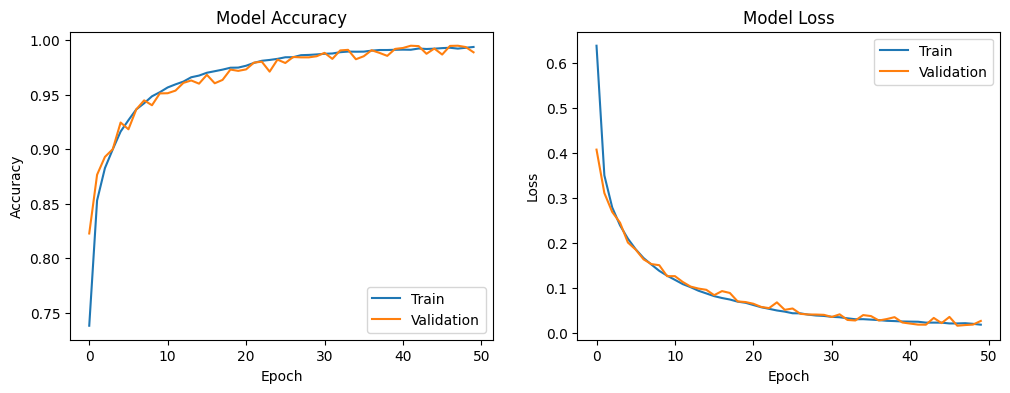

In [ ]:
plot_metrics(history)

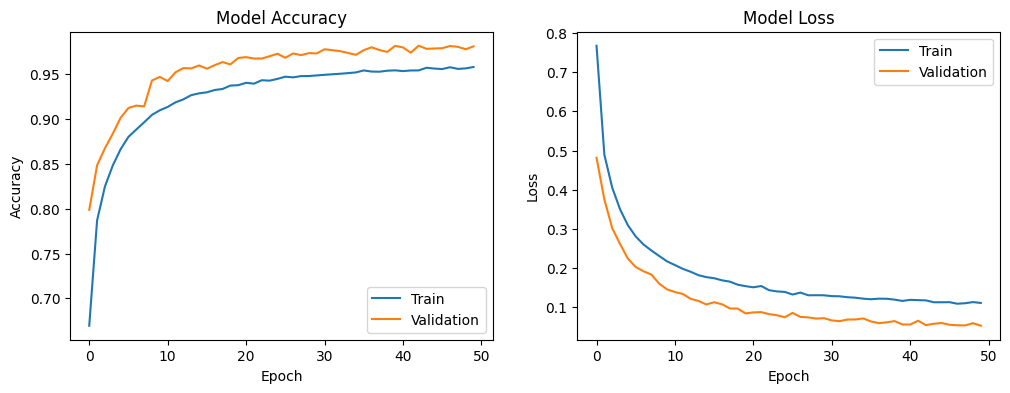

In [ ]:
plot_metrics(cnn_dropout_history)

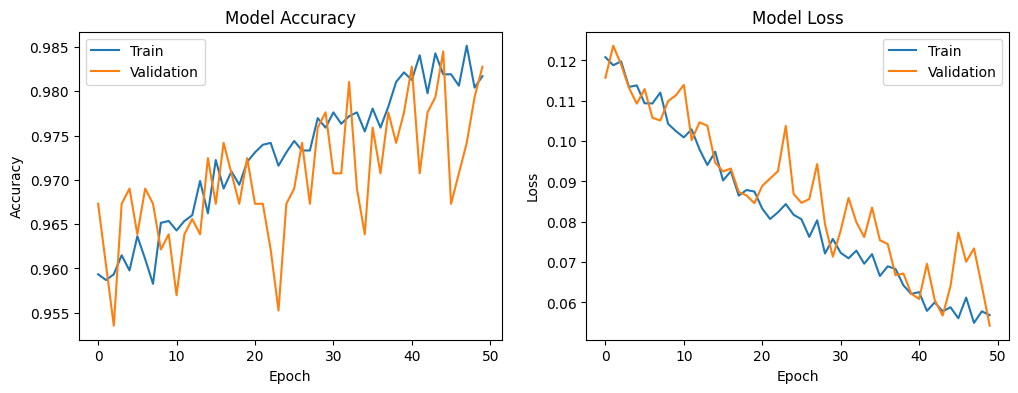

In [ ]:
plot_metrics(noaug_cnn_default_history)

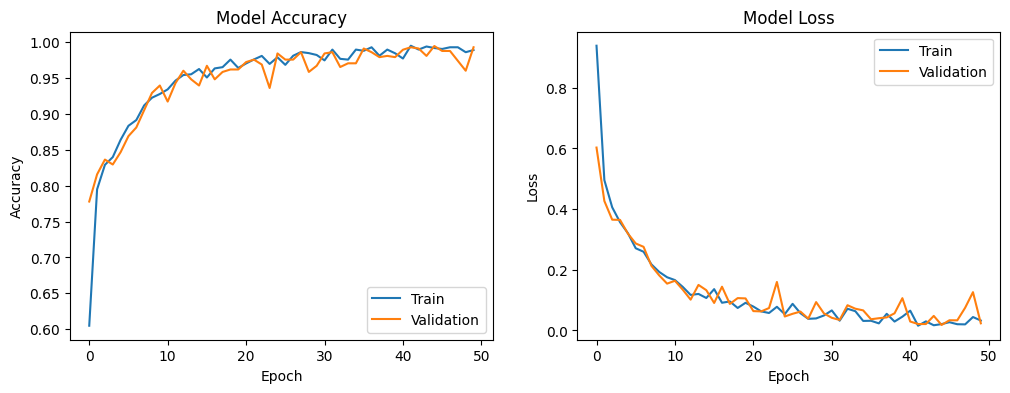

In [ ]:
plot_metrics(noaug_gru_default_history)

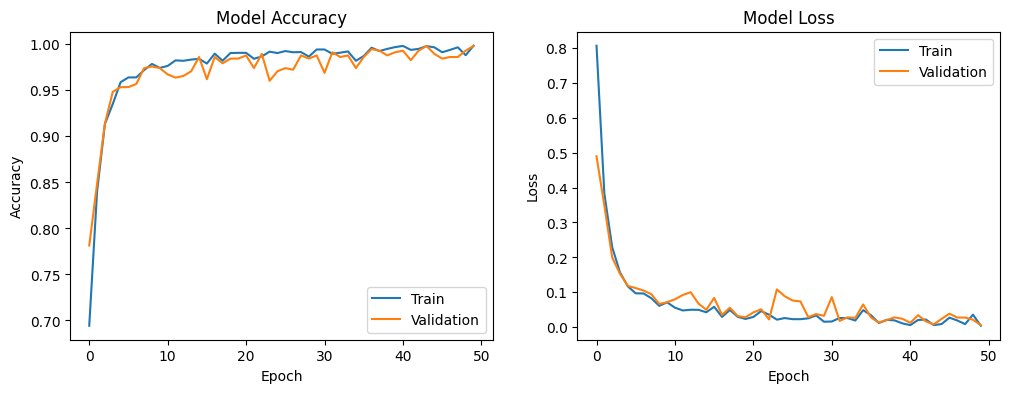

In [ ]:
plot_metrics(noaug_tfm_default_history)

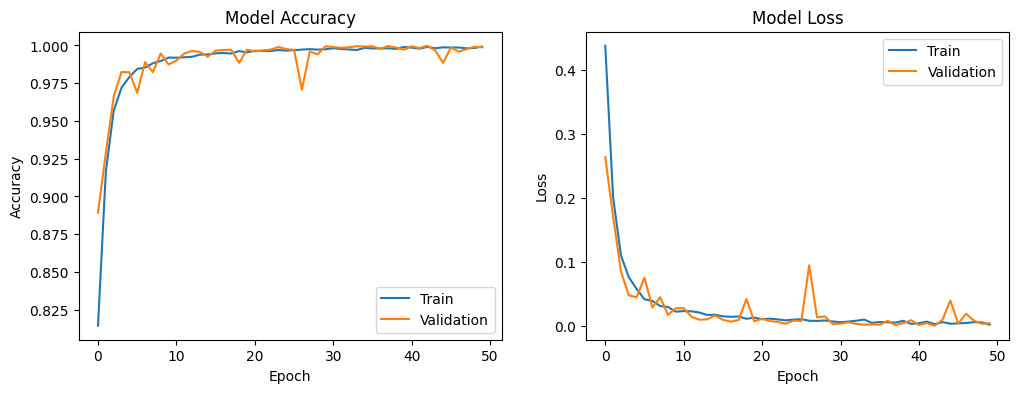

In [ ]:
plot_metrics(gru_default_history)

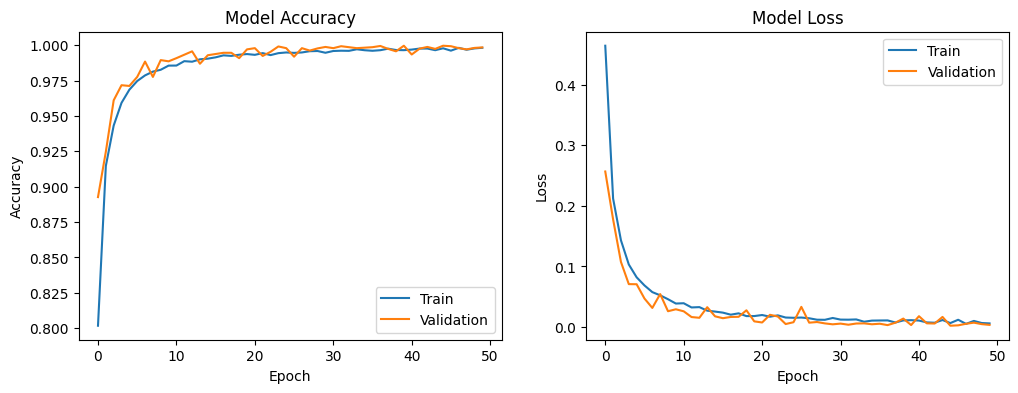

In [ ]:
plot_metrics(gru_dropout_history)

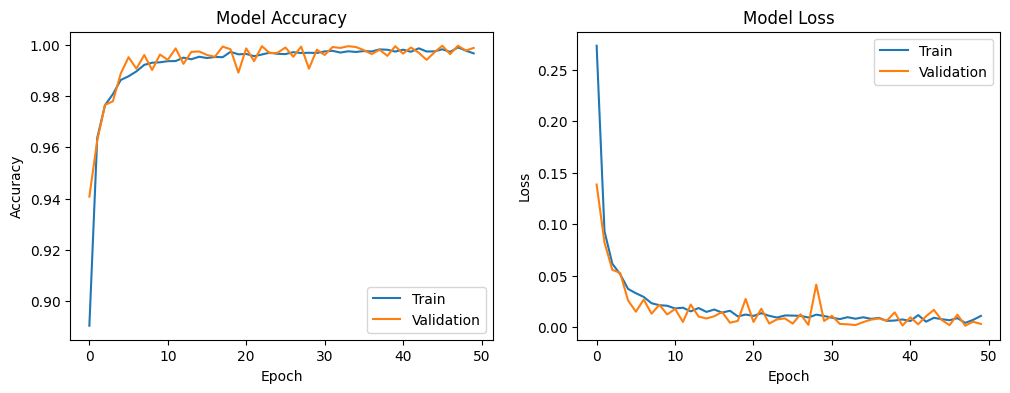

In [ ]:
plot_metrics(tfm_default_history)

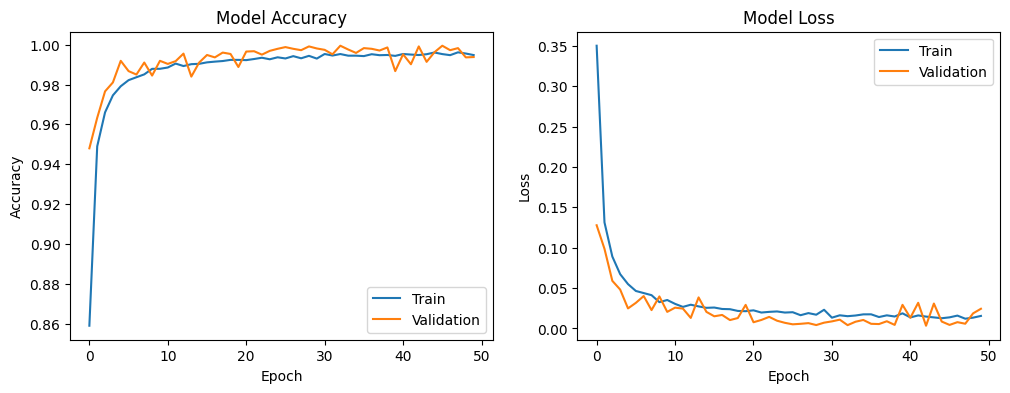

In [ ]:
plot_metrics(tfm_dropout_history)

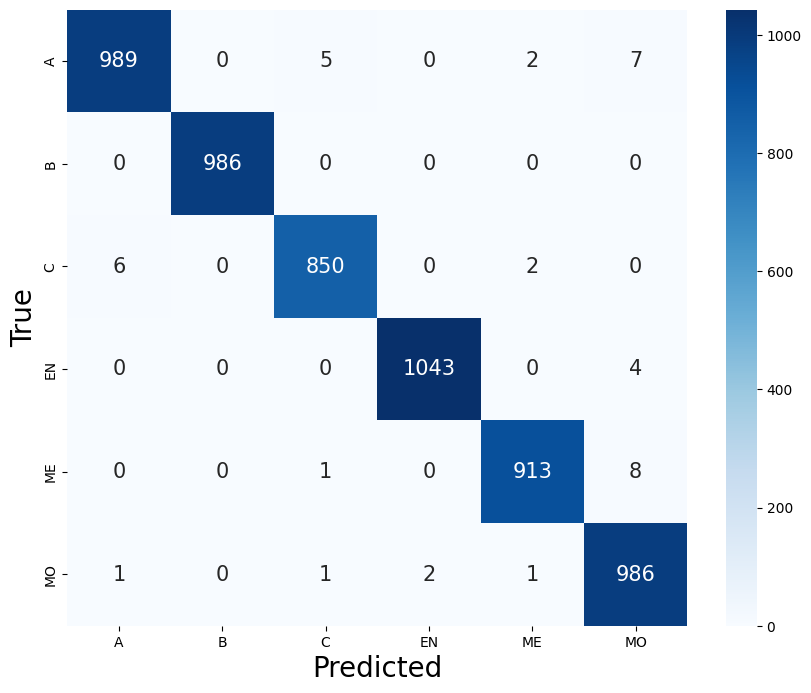

In [ ]:
build_confusion_matrix(true_list_cnn_default, pred_list_cnn_default)

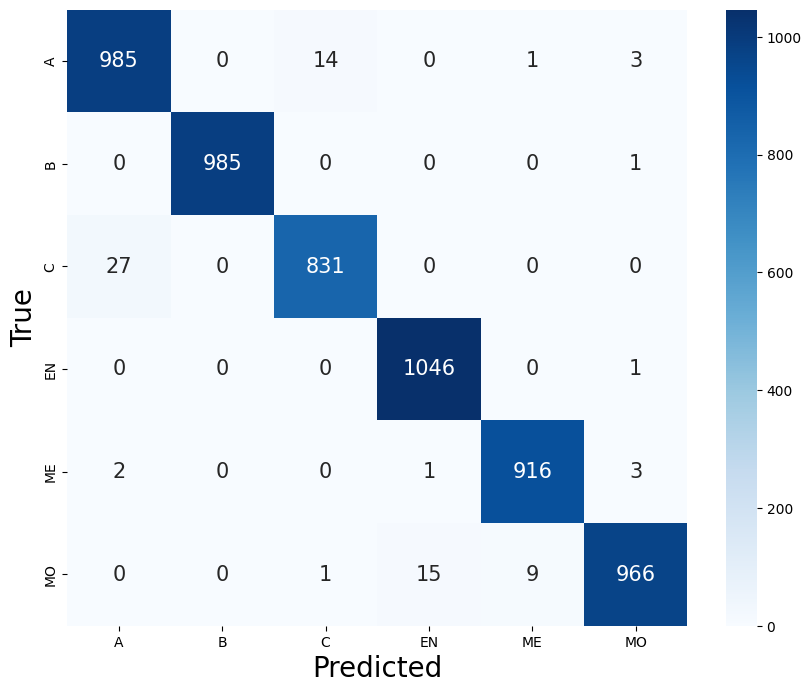

In [ ]:
build_confusion_matrix(true_list_cnn_dropout, pred_list_cnn_dropout)

In [35]:
df_test = create_experiment_number(df_test)
df_test.head()

,C7H8,TMA,VOC,CO2,HCHO,H2S,NH3,CH3SH,SO2,NO2,CO,reg_date,label_type,exp_num
0,0.033189,0.000070,0.511069,100.79880,0.0,0.206896,0.618528,0.0,0.0,0.016224,1.322998,2023-04-03 13:20:34,ME,0.0
1,0.045531,0.000076,0.550266,169.63690,0.0,0.319673,1.126904,0.0,0.0,0.008808,1.365734,2023-04-03 13:20:36,ME,0.0
2,0.060589,0.000080,0.549399,99.92882,0.0,0.450816,1.672414,0.0,0.0,0.002323,1.347419,2023-04-03 13:20:37,ME,0.0
3,0.076748,0.000082,0.550266,70.44612,0.0,0.579394,2.248468,0.0,0.0,0.000000,1.359628,2023-04-03 13:20:39,ME,0.0
4,0.091999,0.000083,0.550266,60.61852,0.0,0.692952,2.811248,0.0,0.0,0.000000,1.310788,2023-04-03 13:20:40,ME,0.0


In [ ]:
# Test Dataloader 구축
# data shape: (batch_size x input_size x seq_len) => (32, 11, 5)
real_test_dataloader = create_test_dataset(df_test, window_size, batch_size, encoder=encoder, scaler=scaler)

In [ ]:
r_pred_list_cnn_default, r_true_list_cnn_default = calculate_metrics(cnn_default_model, real_test_dataloader)

Testing Acc: 0.6842
Test Accuracy   : 0.684
Test Sensitivity: 0.274
Test Precision  : 0.289
Test F1 Score   : 0.280


In [ ]:
r_pred_list_cnn_dropout, r_true_list_cnn_dropout = calculate_metrics(cnn_dropout_model, real_test_dataloader)

Testing Acc: 0.6361
Test Accuracy   : 0.636
Test Sensitivity: 0.320
Test Precision  : 0.355
Test F1 Score   : 0.327


In [ ]:
noaug_r_pred_list_cnn_dropout, noaug_r_true_list_cnn_dropout = calculate_metrics(noaug_cnn_default_model, real_test_dataloader)

Testing Acc: 0.6462
Test Accuracy   : 0.646
Test Sensitivity: 0.431
Test Precision  : 0.480
Test F1 Score   : 0.453


In [ ]:
noaug_r_pred_list_gru_default, noaug_r_true_list_gru_default = calculate_metrics(noaug_gru_default_model, real_test_dataloader)

Testing Acc: 0.5590
Test Accuracy   : 0.559
Test Sensitivity: 0.280
Test Precision  : 0.356
Test F1 Score   : 0.311


In [ ]:
noaug_r_pred_list_tfm_default, noaug_r_true_list_tfm_default = calculate_metrics(noaug_tfm_default_model, real_test_dataloader)

Testing Acc: 0.6690
Test Accuracy   : 0.669
Test Sensitivity: 0.449
Test Precision  : 0.480
Test F1 Score   : 0.451


In [55]:
r_pred_list_gru_default, r_true_list_gru_default = calculate_metrics(gru_default_model, real_test_dataloader)

NameError: ignored

In [ ]:
r_pred_list_gru_dropout, r_true_list_gru_dropout = calculate_metrics(gru_dropout_model, real_test_dataloader)

In [ ]:
r_pred_list_tfm_default, r_true_list_tfm_default = calculate_metrics(tfm_default_model, real_test_dataloader)

Testing Acc: 0.6800
Test Accuracy   : 0.680
Test Sensitivity: 0.456
Test Precision  : 0.477
Test F1 Score   : 0.456


In [104]:
r_pred_list_tfm_dropout, r_true_list_tfm_dropout = calculate_metrics(tfm_dropout_model, real_test_dataloader)

Testing Acc: 0.5987
Test Accuracy   : 0.599
Test Sensitivity: 0.240
Test Precision  : 0.249
Test F1 Score   : 0.244


In [ ]:
encoding_numbers = list(range(0,len(encoder.classes_)))
label_dict = dict(zip(encoding_numbers, encoder.inverse_transform(encoding_numbers)))
print(label_dict)

In [ ]:
# confusion matrix 계산
cm = confusion_matrix(y_true=r_true_list, y_pred=r_pred_list)
cm_df = pd.DataFrame(cm, columns=np.unique(r_pred_list), index=np.unique(r_pred_list))

new_index = [label_dict[i] for i in cm_df.index]
new_columns = [label_dict[i] for i in cm_df.columns]

# 인덱스와 컬럼 이름 변경
cm_df = cm_df.rename(index=dict(zip(cm_df.index, new_index)), columns=dict(zip(cm_df.columns, new_columns)))

# confusion matrix 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(data=cm_df, annot=True, fmt='d', annot_kws={'size': 15}, cmap='Blues')
plt.xlabel('Predicted', size=20)
plt.ylabel('True', size=20)
plt.show()